In [1]:
import numpy as np
import torch 
import pandas as pd
from environment.stockTradingEnv import stockTrading


### Hyperparameters

In [2]:
# LOOKBACK_PERIODS = 5
# EPISODES = 10
# EPOCHS = 200

### Data 

In [3]:
# load data
# change csv as necessary, e.g., 'AMZN.csv' is for analyzing Amazon's stock
raw_data = pd.read_csv('datasets/stocks.csv')
n_features = len(raw_data.columns) - 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# parameters
batch_size = 64
lookback_period = 5
prediction_period = 5

scaled_data = raw_data.iloc[:, 1:].apply(lambda x : (x - min(x)) / (max(x) - min(x)))

# range choices for train-test split
end = int(len(scaled_data) * 0.085)

x_train = scaled_data.iloc[:-end]
stock_closeValues_train = raw_data['Adj Close'].iloc[:-end]

x_valid = scaled_data.iloc[-end:].reset_index(drop=True)
stock_closeValues_valid = raw_data['Adj Close'].iloc[-end:].reset_index(drop=True)

options = pd.read_csv('datasets/options.csv')
options = options[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
options_scaled = options.iloc[:, 1:].apply(lambda x : (x - min(x)) / (max(x) - min(x)))
options_CloseValues = options['Close']

### DQN Deep Q-Network

In [4]:
from Agents.DQN.agent import Agent as DQNAgent
from Agents.DQN.algorithm import BackTest as DQNBackTest
from Agents.DQN.algorithm import run as DQNrun

LOOKBACK_PERIODS = 5
EPISODES = 200
EPOCHS = 10
TARGET_UPDATEFREQ = 10

roi_dqn = []
sharpe_dqn = []
sharpe_matrix_dqn = np.zeros((EPOCHS, EPISODES))
max_profit = -99999999


for epoch_loop in range(EPOCHS):
    # Initialize training environment and agent
    env_training = stockTrading(df = x_train,
                                stock_price_df = stock_closeValues_train, 
                                lookback_period = LOOKBACK_PERIODS,
                                device = device)
   
    agent = DQNAgent(state_size = env_training.n_features,
                    action_size = env_training.action_space.n,
                    device = device)

    # Run training loop
    sharpe_matrix_dqn = DQNrun(sharpe_matrix= sharpe_matrix_dqn,
                                epoch = epoch_loop,
                                agent = agent,
                                env = env_training,
                                device = device,
                                episodes = EPISODES,
                                t_upfreq = TARGET_UPDATEFREQ)

    # Initialize validation environment and perform backtesting

    env_validation = stockTrading(df = x_valid,
                                stock_price_df = stock_closeValues_valid, 
                                lookback_period = LOOKBACK_PERIODS,
                                device = device)


    env_val = DQNBackTest(agent = agent, 
                        env =env_validation,
                        device = device)

    # Collect metrics
    roi_dqn.append(env_val.profit_rate_account[-1] * 100)
    sharpe_dqn.append(env_val.calc_sharpe())
    env_val.render(f'trade_epoch_{epoch_loop}.png', f'profit_epoch_{epoch_loop}.png', options_data =False)

#After loop, you can analyze `roi` and `sharpe` as needed

### A2C Advantage Actor Critic 

In [ ]:
import os 
from Agents.A2C.agent import Agent as A2CAgent
from Agents.A2C.algorithm import BackTest as A2CBackTest
from Agents.A2C.algorithm import run as A2Crun

LOOKBACK_PERIODS = 5
EPISODES = 200
EPOCHS = 10
TARGET_UPDATEFREQ = 10


roi_a2c = []
sharpe_a2c = []
sharpe_matrix_a2c = np.zeros((EPOCHS, EPISODES))
max_profit = -99999999


for epoch_loop in range(EPOCHS):
    # Initialize training environment and agent
    env_training = stockTrading(df = x_train,
                                stock_price_df = stock_closeValues_train,
                                lookback_period=LOOKBACK_PERIODS,
                                device = device)

    agent = A2CAgent(state_size=env_training.n_features,
                    action_size=env_training.action_space.n,
                    device = device)

    # Run training loop
    sharpe_matrix_a2c = A2Crun(sharpe_matrix =sharpe_matrix_a2c,
                                epoch = epoch_loop, 
                                agent = agent,
                                env = env_training, 
                                device = device,
                                episodes = EPISODES,
                                t_upfreq = TARGET_UPDATEFREQ)

    # Initialize validation environment and perform backtesting
    env_validation = stockTrading(df =x_valid,
                                stock_price_df= stock_closeValues_valid,
                                lookback_period=LOOKBACK_PERIODS,
                                device = device)

    env_val = A2CBackTest(agent =agent,
                         env =  env_validation,
                         device = device)

    # Collect metrics
    roi_a2c.append(env_val.profit_rate_account[-1] * 100)
    sharpe_a2c.append(env_val.calc_sharpe())
    env_val.render(f'trade_epoch_{epoch_loop}.png', f'profit_epoch_{epoch_loop}.png', options_data = False)

### PPO - Proximal Policy Optimization 

Episode:0, total_profit:10978848.220, sharpe:0.593
Episode:1, total_profit:3813551.861, sharpe:0.419
Episode:2, total_profit:11040826.864, sharpe:0.586
Episode:3, total_profit:11366289.487, sharpe:0.594
Episode:4, total_profit:9838746.627, sharpe:0.567
Episode:5, total_profit:2519379.472, sharpe:0.367
Episode:6, total_profit:7948511.784, sharpe:0.537
Episode:7, total_profit:12375522.559, sharpe:0.610
Episode:8, total_profit:39278668.322, sharpe:0.811
Episode:9, total_profit:3954975.591, sharpe:0.436
Episode:10, total_profit:4374327.534, sharpe:0.450
Episode:11, total_profit:7028633.149, sharpe:0.521
Episode:12, total_profit:9396525.377, sharpe:0.562
Episode:13, total_profit:21791463.724, sharpe:0.708
Episode:14, total_profit:1941213.344, sharpe:0.333
Episode:15, total_profit:9191503.216, sharpe:0.562
Episode:16, total_profit:12656218.574, sharpe:0.618
Episode:17, total_profit:18764281.077, sharpe:0.694
Episode:18, total_profit:558611.774, sharpe:0.215
Episode:19, total_profit:3520125.6

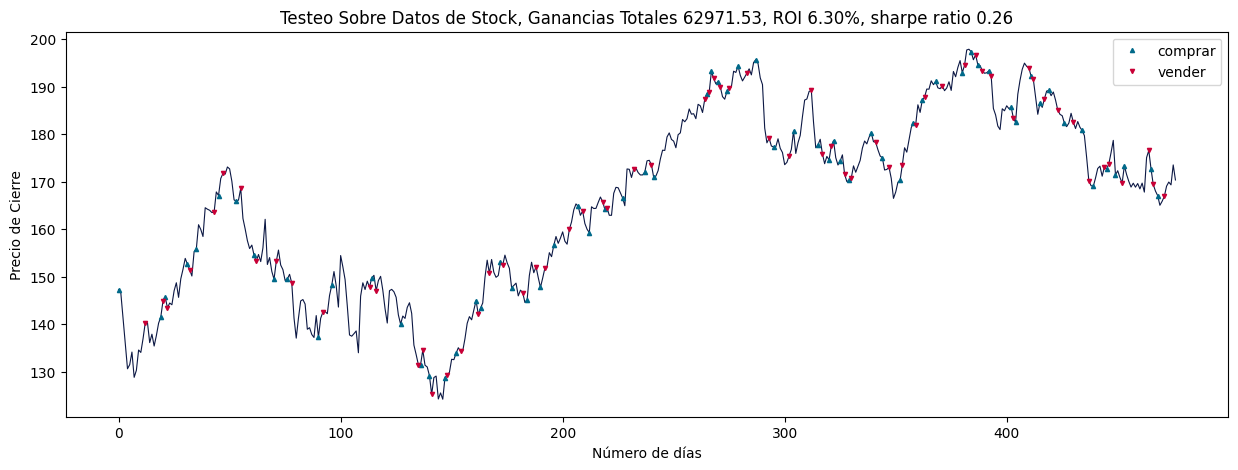

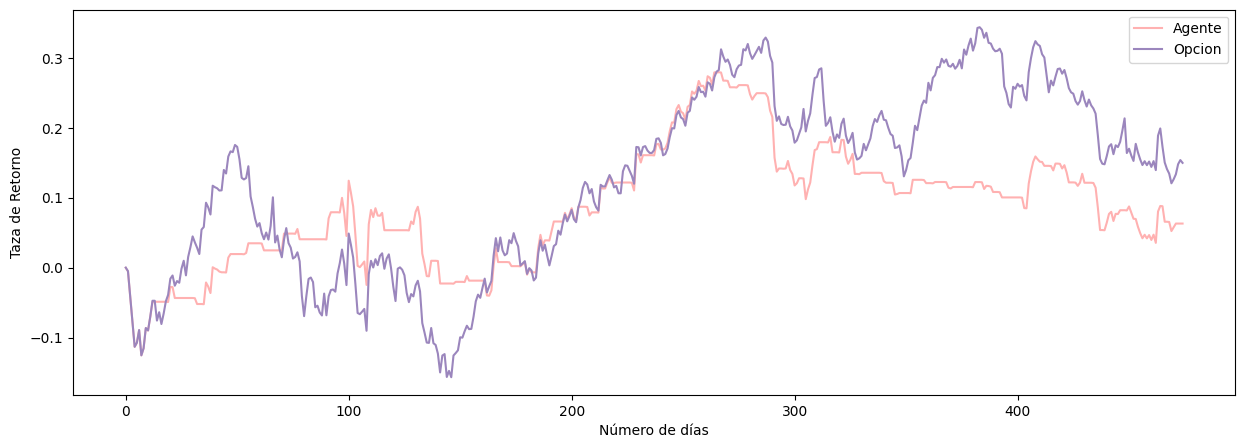

Episode:0, total_profit:15992683.883, sharpe:0.619
Episode:1, total_profit:6298969.765, sharpe:0.477
Episode:2, total_profit:37867887.387, sharpe:0.764
Episode:3, total_profit:33113417.879, sharpe:0.736
Episode:4, total_profit:27850484.285, sharpe:0.711
Episode:5, total_profit:44315646.476, sharpe:0.800
Episode:6, total_profit:14617439.651, sharpe:0.608
Episode:7, total_profit:47108023.953, sharpe:0.788
Episode:8, total_profit:12728764.272, sharpe:0.580
Episode:9, total_profit:36328638.044, sharpe:0.766
Episode:10, total_profit:9431656.920, sharpe:0.541
Episode:11, total_profit:3840136.733, sharpe:0.408
Episode:12, total_profit:23619620.215, sharpe:0.676
Episode:13, total_profit:19190720.948, sharpe:0.653
Episode:14, total_profit:14649076.691, sharpe:0.602
Episode:15, total_profit:26210193.443, sharpe:0.711
Episode:16, total_profit:59267374.250, sharpe:0.834
Episode:17, total_profit:49725618.959, sharpe:0.802
Episode:18, total_profit:10724358.168, sharpe:0.557
Episode:19, total_profit:

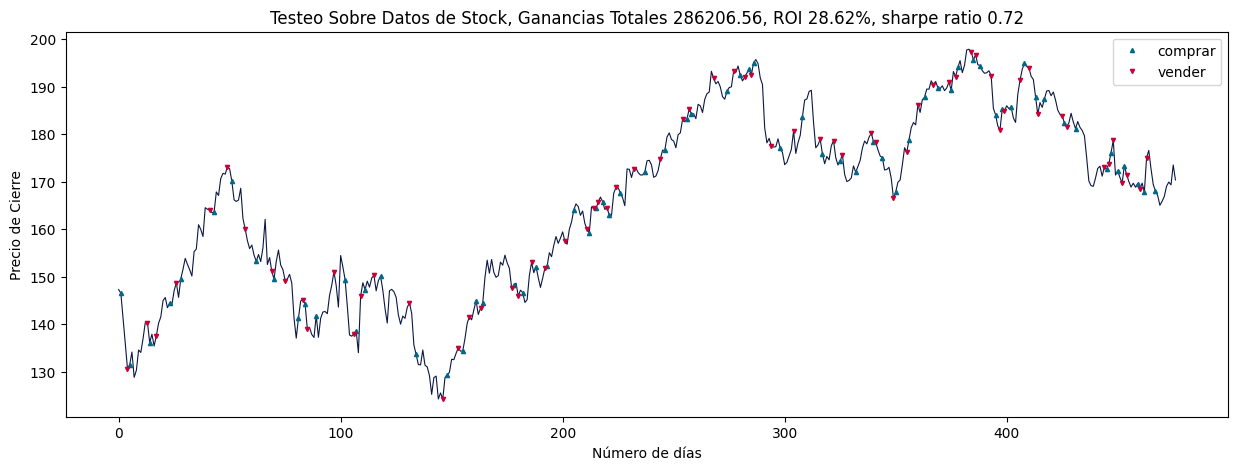

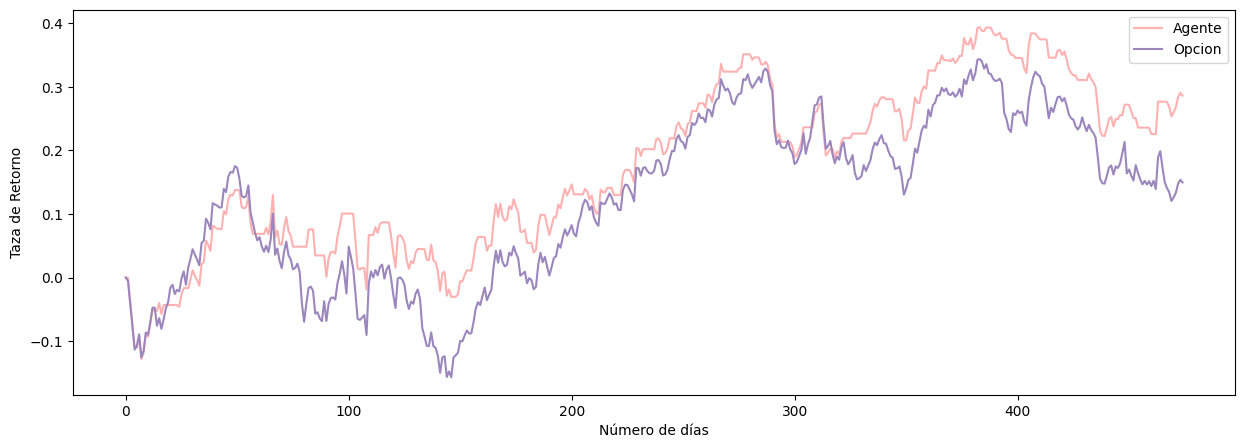

Episode:0, total_profit:274854.851, sharpe:0.171
Episode:1, total_profit:1021187.201, sharpe:0.265
Episode:2, total_profit:2909861.410, sharpe:0.398
Episode:3, total_profit:11712615.780, sharpe:0.659
Episode:4, total_profit:6217303.653, sharpe:0.521
Episode:5, total_profit:-339350.045, sharpe:0.034
Episode:6, total_profit:13491467.873, sharpe:0.677
Episode:7, total_profit:2015161.351, sharpe:0.345
Episode:8, total_profit:1311786.110, sharpe:0.293
Episode:9, total_profit:2531513.388, sharpe:0.378
Episode:10, total_profit:3785392.141, sharpe:0.440
Episode:11, total_profit:1861525.794, sharpe:0.332
Episode:12, total_profit:120906.506, sharpe:0.142
Episode:13, total_profit:1266822.957, sharpe:0.288
Episode:14, total_profit:1072691.993, sharpe:0.270
Episode:15, total_profit:2392229.663, sharpe:0.371
Episode:16, total_profit:-358516.856, sharpe:0.032
Episode:17, total_profit:-324758.773, sharpe:0.037
Episode:18, total_profit:4605912.115, sharpe:0.471
Episode:19, total_profit:3844938.522, sha

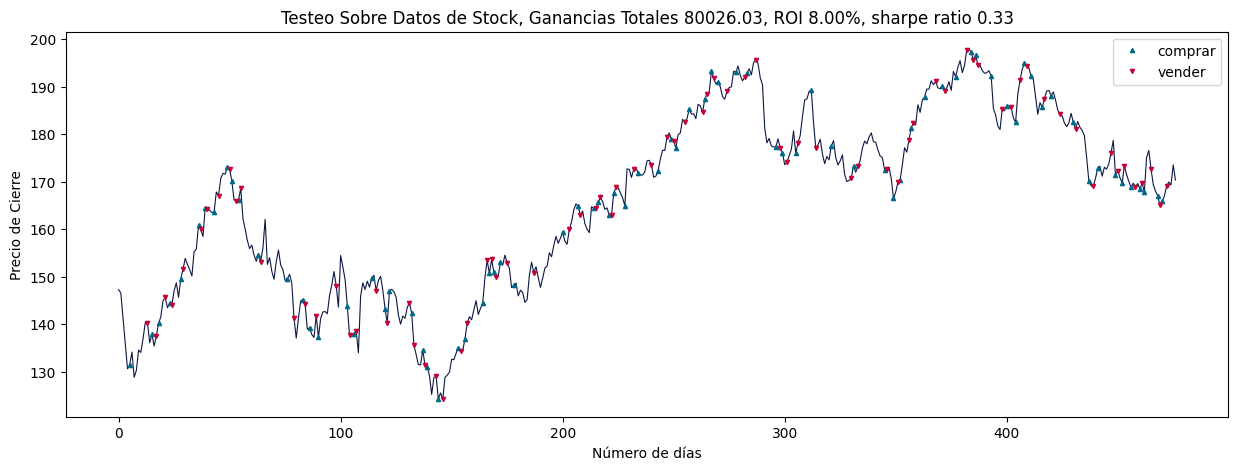

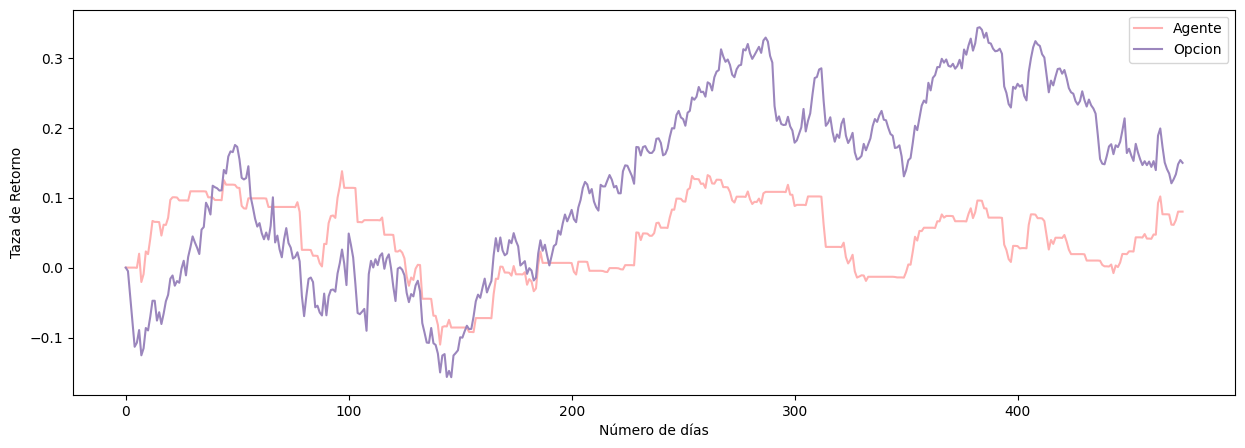

Episode:0, total_profit:6365314.616, sharpe:0.497
Episode:1, total_profit:2103621.149, sharpe:0.342
Episode:2, total_profit:13369399.452, sharpe:0.623
Episode:3, total_profit:3891123.374, sharpe:0.426
Episode:4, total_profit:4709889.000, sharpe:0.461
Episode:5, total_profit:19151502.746, sharpe:0.688
Episode:6, total_profit:4918765.454, sharpe:0.465
Episode:7, total_profit:15514938.524, sharpe:0.644
Episode:8, total_profit:8171020.097, sharpe:0.538
Episode:9, total_profit:9358998.848, sharpe:0.552
Episode:10, total_profit:2189479.047, sharpe:0.347
Episode:11, total_profit:9306037.317, sharpe:0.558
Episode:12, total_profit:2682272.340, sharpe:0.374
Episode:13, total_profit:8317010.792, sharpe:0.543
Episode:14, total_profit:3645537.036, sharpe:0.414
Episode:15, total_profit:2805058.941, sharpe:0.379
Episode:16, total_profit:10295451.771, sharpe:0.578
Episode:17, total_profit:6295344.373, sharpe:0.501
Episode:18, total_profit:5707849.304, sharpe:0.480
Episode:19, total_profit:6466546.107,

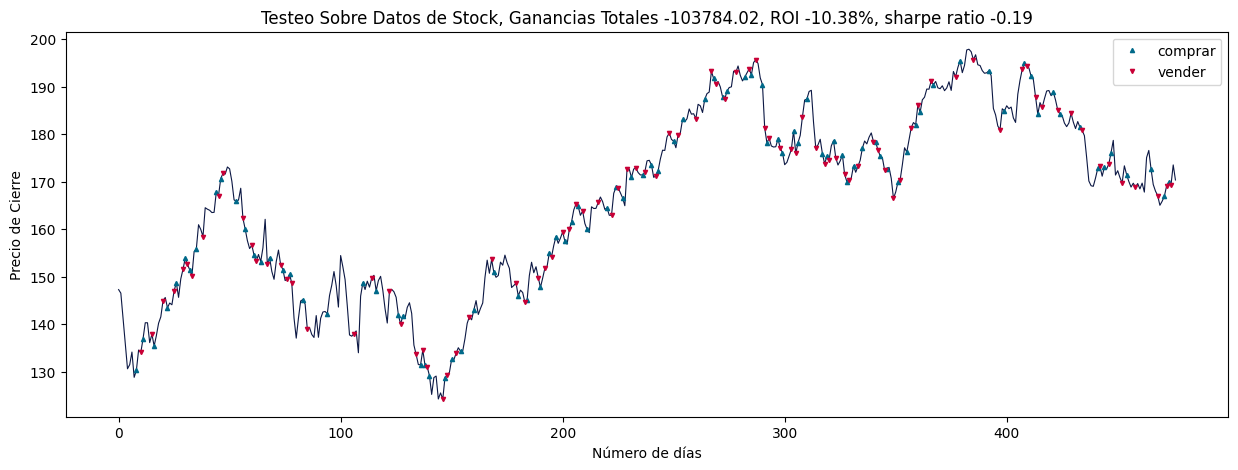

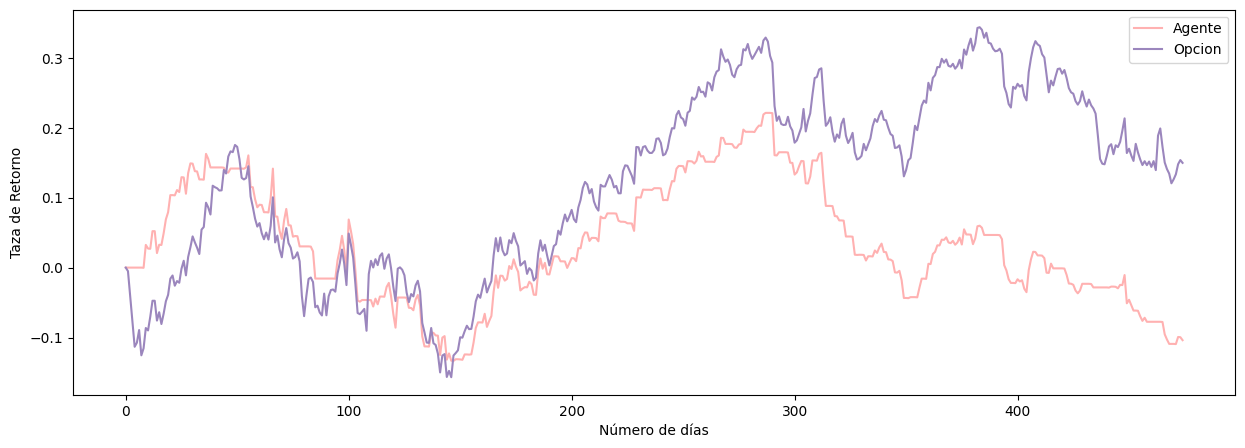

Episode:0, total_profit:774086.048, sharpe:0.238
Episode:1, total_profit:398227.670, sharpe:0.194
Episode:2, total_profit:459899.539, sharpe:0.200
Episode:3, total_profit:13093475.266, sharpe:0.635
Episode:4, total_profit:10795563.649, sharpe:0.594
Episode:5, total_profit:3040860.409, sharpe:0.397
Episode:6, total_profit:1247172.222, sharpe:0.283
Episode:7, total_profit:7840698.354, sharpe:0.544
Episode:8, total_profit:1688629.829, sharpe:0.318
Episode:9, total_profit:5211713.311, sharpe:0.475
Episode:10, total_profit:-161092.704, sharpe:0.094
Episode:11, total_profit:4743582.420, sharpe:0.464
Episode:12, total_profit:652475.839, sharpe:0.223
Episode:13, total_profit:-206329.055, sharpe:0.089
Episode:14, total_profit:2204483.652, sharpe:0.354
Episode:15, total_profit:1338834.620, sharpe:0.290
Episode:16, total_profit:66698986.407, sharpe:0.922
Episode:17, total_profit:26612.467, sharpe:0.134
Episode:18, total_profit:666598.763, sharpe:0.226
Episode:19, total_profit:2150643.781, sharpe:

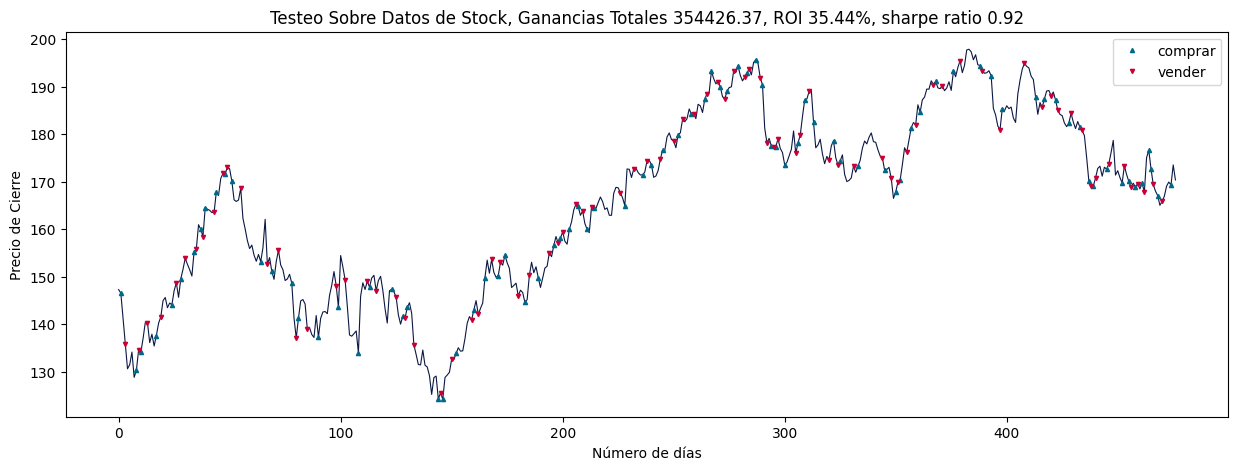

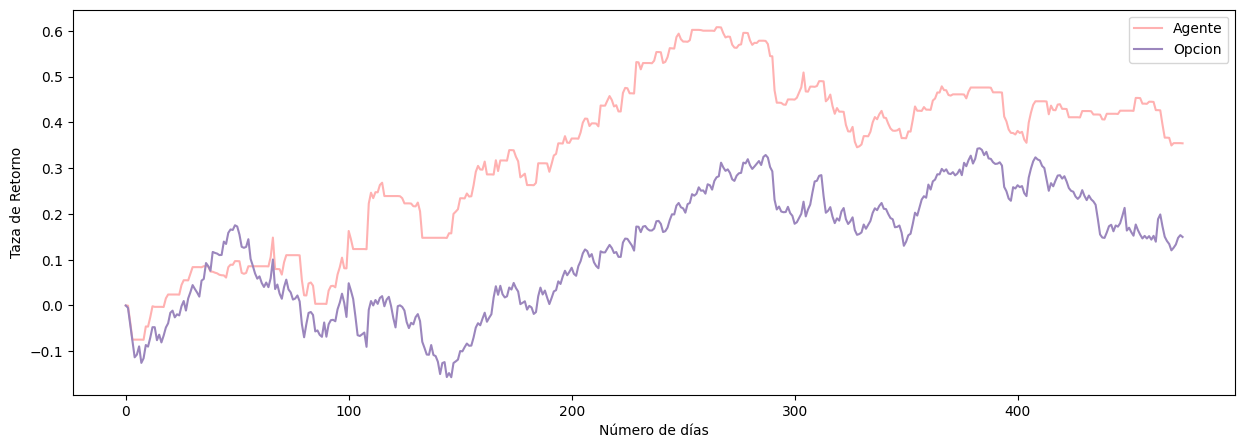

Episode:0, total_profit:19574213.428, sharpe:0.707
Episode:1, total_profit:12436838.386, sharpe:0.633
Episode:2, total_profit:9782183.344, sharpe:0.608
Episode:3, total_profit:7377825.125, sharpe:0.545
Episode:4, total_profit:5876130.226, sharpe:0.511
Episode:5, total_profit:4405403.239, sharpe:0.450
Episode:6, total_profit:9585491.154, sharpe:0.586
Episode:7, total_profit:11011519.513, sharpe:0.624
Episode:8, total_profit:8287039.090, sharpe:0.561
Episode:9, total_profit:5229170.544, sharpe:0.479
Episode:10, total_profit:13222305.580, sharpe:0.654
Episode:11, total_profit:2993163.699, sharpe:0.400
Episode:12, total_profit:3011740.709, sharpe:0.402
Episode:13, total_profit:2689463.299, sharpe:0.380
Episode:14, total_profit:16312243.774, sharpe:0.690
Episode:15, total_profit:1425009.133, sharpe:0.298
Episode:16, total_profit:4821158.828, sharpe:0.472
Episode:17, total_profit:1190679.418, sharpe:0.278
Episode:18, total_profit:21652373.313, sharpe:0.724
Episode:19, total_profit:12856241.9

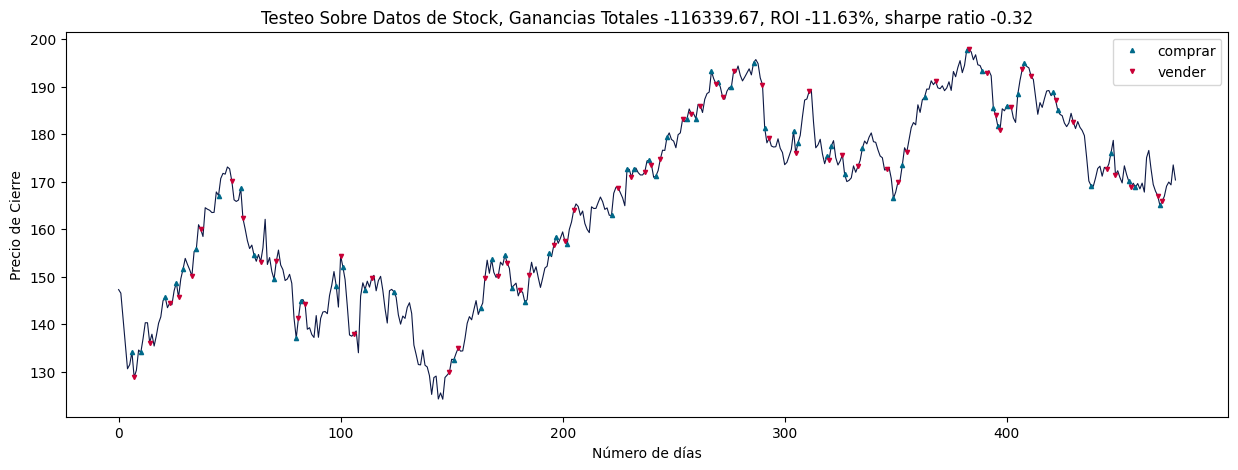

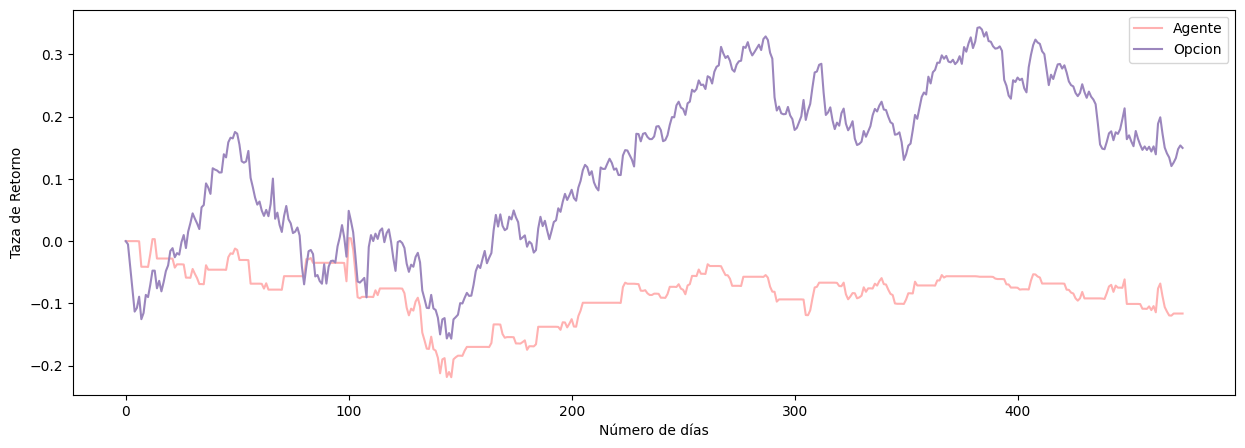

Episode:0, total_profit:6479313.259, sharpe:0.487
Episode:1, total_profit:10721592.478, sharpe:0.568
Episode:2, total_profit:19300542.842, sharpe:0.668
Episode:3, total_profit:87699050.576, sharpe:0.915
Episode:4, total_profit:74143042.336, sharpe:0.881
Episode:5, total_profit:7121176.207, sharpe:0.503
Episode:6, total_profit:9482679.074, sharpe:0.539
Episode:7, total_profit:16645297.459, sharpe:0.637
Episode:8, total_profit:9139773.669, sharpe:0.547
Episode:9, total_profit:47782390.667, sharpe:0.815
Episode:10, total_profit:3296743.353, sharpe:0.394
Episode:11, total_profit:15032304.421, sharpe:0.615
Episode:12, total_profit:77939481.839, sharpe:0.889
Episode:13, total_profit:18301722.226, sharpe:0.650
Episode:14, total_profit:12360637.812, sharpe:0.589
Episode:15, total_profit:5694067.167, sharpe:0.469
Episode:16, total_profit:6330181.635, sharpe:0.485
Episode:17, total_profit:22181167.042, sharpe:0.673
Episode:18, total_profit:15082461.177, sharpe:0.610
Episode:19, total_profit:1244

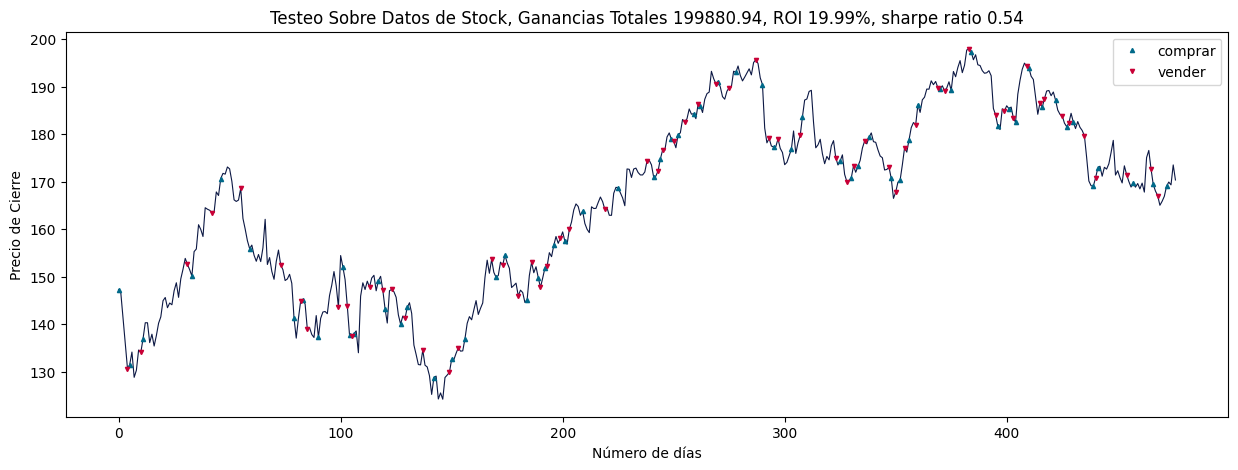

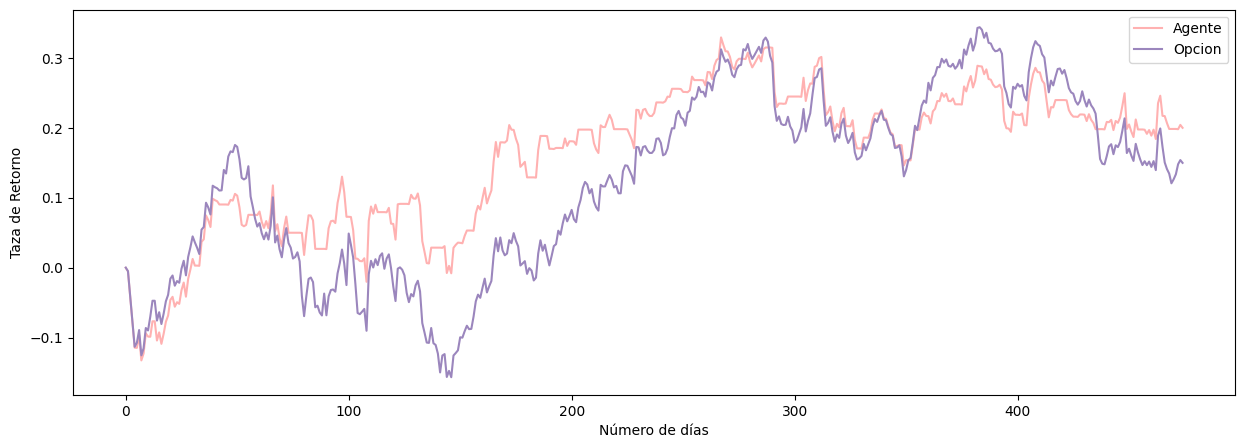

Episode:0, total_profit:46850885.738, sharpe:0.782
Episode:1, total_profit:26569205.228, sharpe:0.689
Episode:2, total_profit:25548834.215, sharpe:0.676
Episode:3, total_profit:142827909.483, sharpe:0.955
Episode:4, total_profit:122381271.527, sharpe:0.938
Episode:5, total_profit:7345106.123, sharpe:0.496
Episode:6, total_profit:62128099.296, sharpe:0.823
Episode:7, total_profit:41824057.328, sharpe:0.754
Episode:8, total_profit:33046913.125, sharpe:0.726
Episode:9, total_profit:23117832.789, sharpe:0.676
Episode:10, total_profit:17602036.112, sharpe:0.628
Episode:11, total_profit:58309561.251, sharpe:0.827
Episode:12, total_profit:30409785.783, sharpe:0.709
Episode:13, total_profit:22378880.355, sharpe:0.654
Episode:14, total_profit:41892155.219, sharpe:0.763
Episode:15, total_profit:64480675.782, sharpe:0.839
Episode:16, total_profit:8416195.407, sharpe:0.513
Episode:17, total_profit:36975797.459, sharpe:0.753
Episode:18, total_profit:26505604.939, sharpe:0.696
Episode:19, total_prof

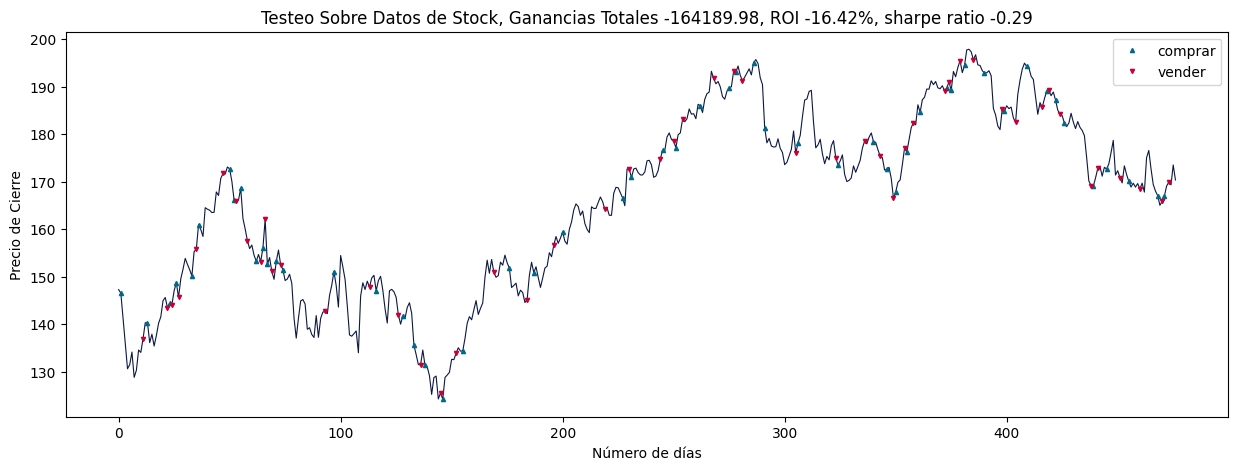

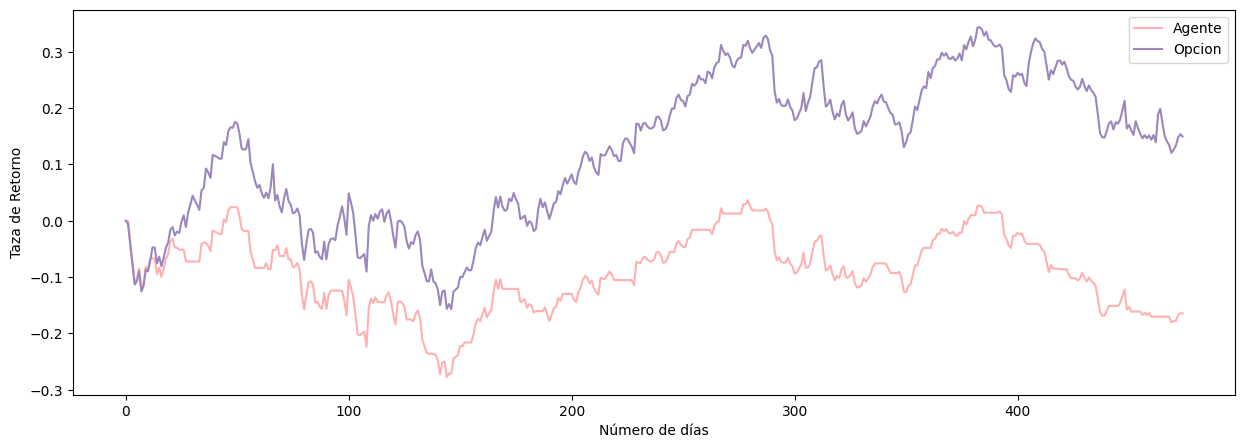

Episode:0, total_profit:6169795.260, sharpe:0.486
Episode:1, total_profit:7505559.043, sharpe:0.515
Episode:2, total_profit:6625498.330, sharpe:0.498
Episode:3, total_profit:9870267.493, sharpe:0.557
Episode:4, total_profit:2285686.452, sharpe:0.351
Episode:5, total_profit:10718410.317, sharpe:0.581
Episode:6, total_profit:13264163.979, sharpe:0.608
Episode:7, total_profit:10493431.215, sharpe:0.570
Episode:8, total_profit:11102401.766, sharpe:0.577
Episode:9, total_profit:8228327.513, sharpe:0.544
Episode:10, total_profit:13326949.796, sharpe:0.614
Episode:11, total_profit:10152005.573, sharpe:0.563
Episode:12, total_profit:38921691.899, sharpe:0.791
Episode:13, total_profit:51522842.573, sharpe:0.841
Episode:14, total_profit:2508165.661, sharpe:0.364
Episode:15, total_profit:14319022.523, sharpe:0.626
Episode:16, total_profit:8561492.050, sharpe:0.540
Episode:17, total_profit:6808653.585, sharpe:0.515
Episode:18, total_profit:9221176.413, sharpe:0.546
Episode:19, total_profit:2427555

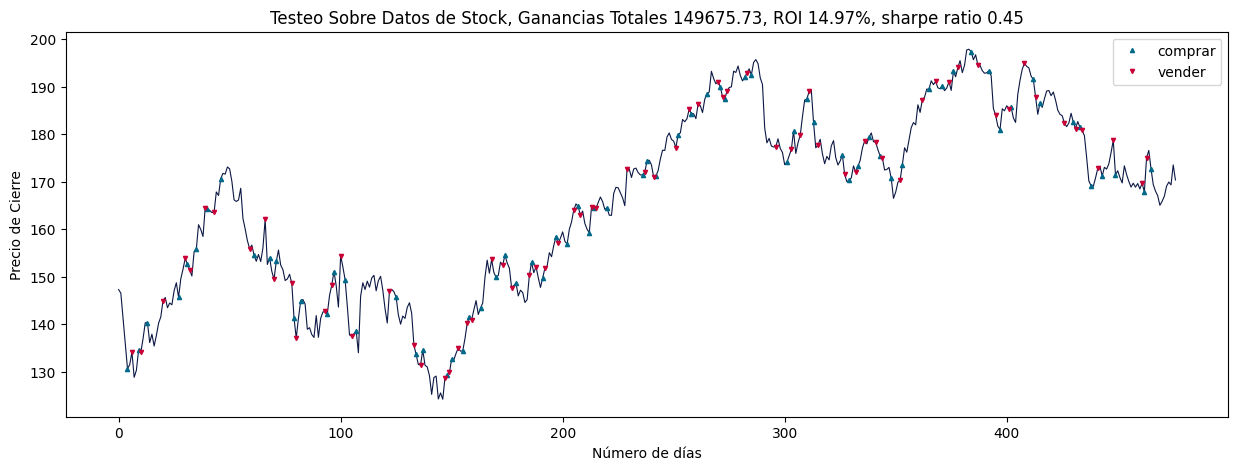

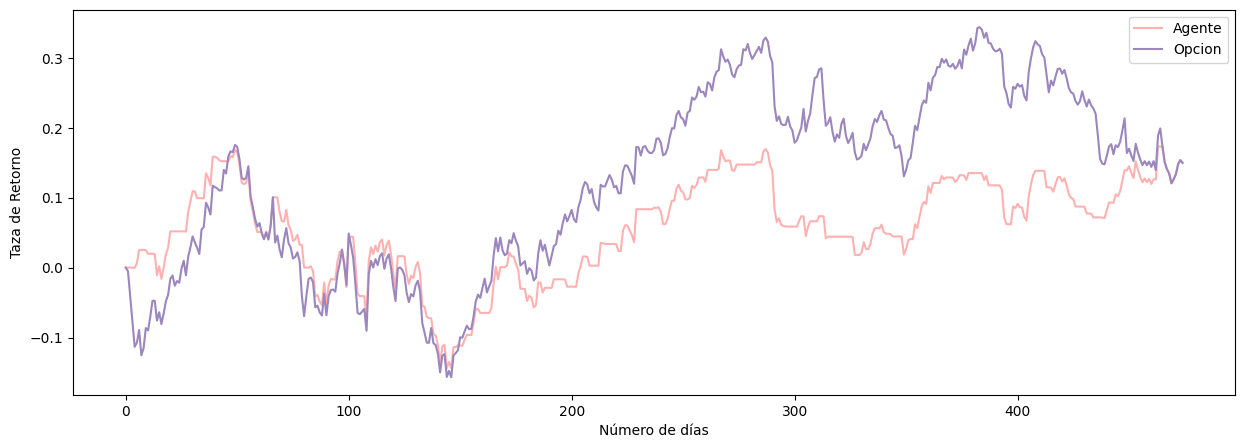

Episode:0, total_profit:3425608.453, sharpe:0.450
Episode:1, total_profit:20511533.206, sharpe:0.778
Episode:2, total_profit:7561306.185, sharpe:0.576
Episode:3, total_profit:2244808.253, sharpe:0.372
Episode:4, total_profit:-89316.158, sharpe:0.094
Episode:5, total_profit:3217104.285, sharpe:0.438
Episode:6, total_profit:5623364.353, sharpe:0.515
Episode:7, total_profit:876218.846, sharpe:0.251
Episode:8, total_profit:143193.829, sharpe:0.141
Episode:9, total_profit:2053674.859, sharpe:0.359
Episode:10, total_profit:3316498.258, sharpe:0.436
Episode:11, total_profit:853605.354, sharpe:0.247
Episode:12, total_profit:-349929.115, sharpe:0.000
Episode:13, total_profit:4621946.500, sharpe:0.489
Episode:14, total_profit:-142585.100, sharpe:0.077
Episode:15, total_profit:17150579.647, sharpe:0.741
Episode:16, total_profit:803742.886, sharpe:0.241
Episode:17, total_profit:4479697.332, sharpe:0.483
Episode:18, total_profit:2046002.564, sharpe:0.359
Episode:19, total_profit:3506431.395, sharpe

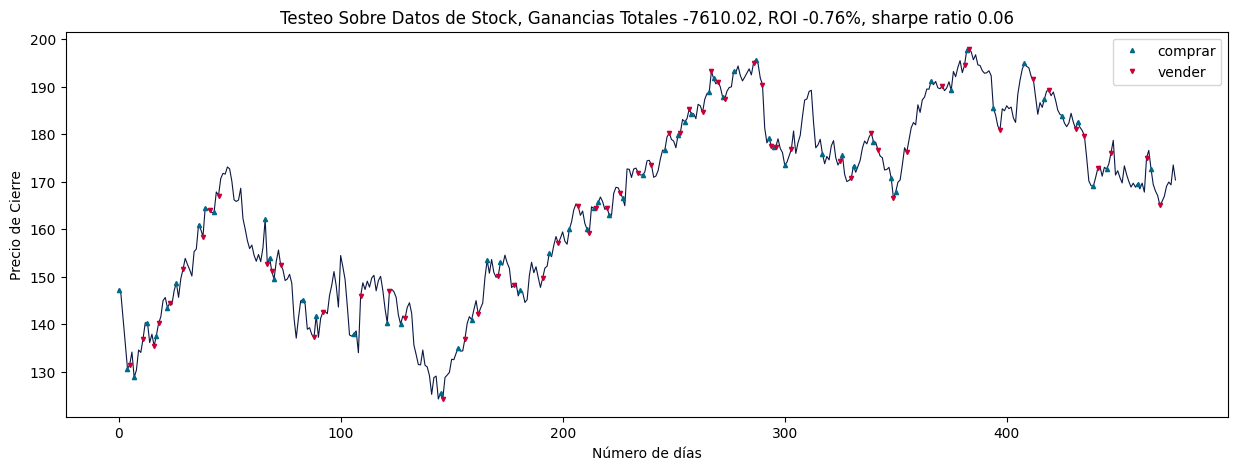

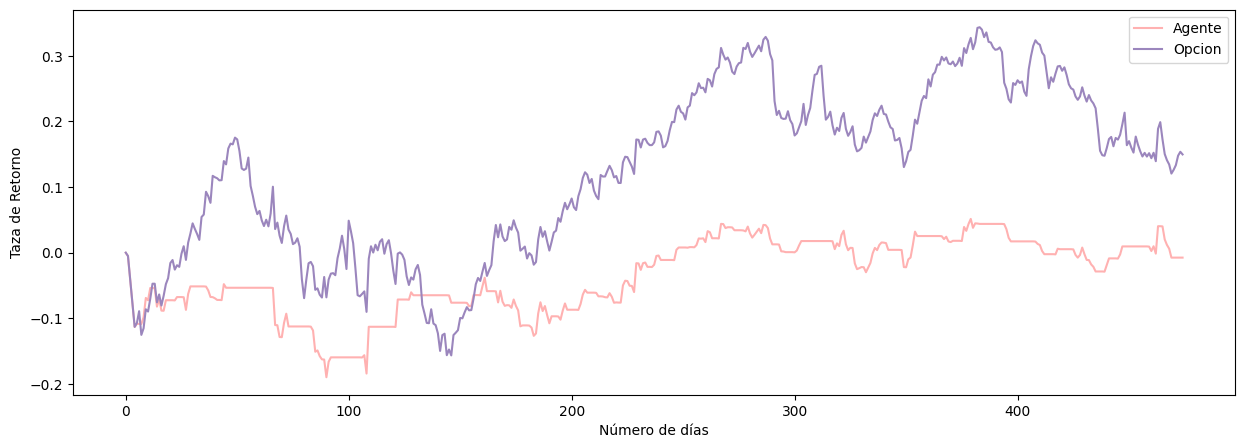

In [6]:
from Agents.PPO.agent import Agent as PPOAgent
from Agents.PPO.algorithm import BackTest as PPOBackTest
from Agents.PPO.algorithm import run as PPOrun

EPISODES = 300
EPOCHS = 10
LOOKBACK_PERIODS = 5
TARGET_UPDATEFREQ = 10

roi_ppo = []
sharpe_ppo = []
sharpe_matrix_ppo = np.zeros((EPOCHS, EPISODES))
max_profit = -99999999


for epoch_loop in range(EPOCHS):
    # Initialize training environment and agent
    env_training = stockTrading(df = x_train,
                                stock_price_df = stock_closeValues_train,
                                lookback_period=LOOKBACK_PERIODS,
                                device = device)

    agent = PPOAgent(state_size=env_training.n_features,
                     action_size=env_training.action_space.n,
                     device = device)

    # Run training loop
    sharpe_matrix_ppo = PPOrun(sharpe_matrix = sharpe_matrix_ppo,
                                epoch = epoch_loop,
                                agent = agent, 
                                env = env_training,
                                device = device,
                                episodes = EPISODES,
                                )

    # Initialize validation environment and perform backtesting
    env_validation = stockTrading(df =x_valid,
                                 stock_price_df = stock_closeValues_valid,
                                 lookback_period=LOOKBACK_PERIODS,
                                 device = device)

    env_val = PPOBackTest(agent = agent,
                          env = env_validation,
                          device = device)

    # Collect metrics
    roi_ppo.append(env_val.profit_rate_account[-1] * 100)
    sharpe_ppo.append(env_val.calc_sharpe())
    env_val.render(f'trade_epoch_{epoch_loop}.png', f'profit_epoch_{epoch_loop}.png', options_data =False)

[[0.59321821 0.41873991 0.58565422 ... 0.54995433 0.12412706 0.40552615]
 [0.6185521  0.47731166 0.76380694 ... 0.62760259 0.79893697 0.27381991]
 [0.17107573 0.26501729 0.39829836 ... 0.29513661 0.18755089 0.35991335]
 ...
 [0.78193792 0.68924445 0.67586199 ... 0.75177456 0.81789669 0.87723245]
 [0.48593853 0.51507011 0.49801085 ... 0.64187804 0.37108499 0.61549545]
 [0.4501041  0.77776083 0.57582022 ... 0.26063003 0.50217581 0.34753978]]
